In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.callbacks import TQDMProgressBar

%run xception.ipynb

In [3]:
# !wget -O ./data/data_v1.npz https://s3.amazonaws.com/measure.galaxies/data_v1.npz

In [4]:
# Load denoised log-images
basedir = Path(".")
dataset = basedir / "./data/data_v1.npz"
modelpath = "./models/xception_log.tf"

with np.load(dataset) as data:
    print("Available variables:", data.files)
    image = data["img_nonoise"]
    label = data["label"]

Available variables: ['img', 'img_nonoise', 'label', 'psf_r', 'snr', 'sigma']


In [5]:
# Use unscaled images. Let TF normalize the data.
assert image.min() > -1
X = np.log(image[..., np.newaxis] + 1)
input_shape = X.shape[1:]

# Scale the labels between -1 and 1 using the full dataset. We know the ranges of generated labels.
scaler = MinMaxScaler(feature_range=(-1, 1))
y = scaler.fit_transform(label)
output_shape = y.shape[1:]

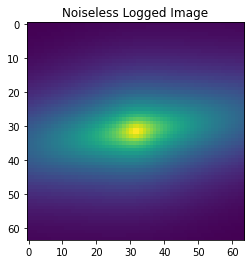

In [6]:
plt.imshow(X[0].reshape(64, 64))
plt.title("Noiseless Logged Image");

In [7]:
# Build a small Xception model
model = build_xception_model(
    input_shape, output_shape, conv2d_num_filters=16, sep_num_filters=64, num_residual_blocks=8
)
# Adapt the normalization layer to the data
adapt_model(model, X);
# model.summary()

In [8]:
# Setup callbacks. TQDM is used due to issues with the default progress bar on my TF2.1 installation.
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
tqdm_callback = TQDMProgressBar()
checkpoint = ModelCheckpoint(modelpath, save_best_only=True)

# Train the Xception model on the full dataset
model.compile(optimizer=Adam(0.0001), loss="mse")
history = model.fit(
    X,
    y,
    batch_size=32,
    epochs=100,
    validation_split=0.1,
    verbose=2,
    callbacks=[early_stopping, checkpoint],
)
model.save(modelpath)

Train on 180000 samples, validate on 20000 samples
Epoch 1/100
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./models/xception_log.tf/assets
180000/180000 - 108s - loss: 0.0835 - val_loss: 0.0651
Epoch 2/100
INFO:tensorflow:Assets written to: ./models/xception_log.tf/assets
180000/180000 - 104s - loss: 0.0460 - val_loss: 0.0245
Epoch 3/100
INFO:tensorflow:Assets written to: ./models/xception_log.tf/assets
180000/180000 - 103s - loss: 0.0195 - val_loss: 0.0160
Epoch 4/100
INFO:tensorflow:Assets written to: ./models/xception_log.tf/assets
180000/180000 - 103s - loss: 0.0126 - val_loss: 0.0124
Epoch 5/100
INFO:tensorflow:Assets written to: ./models/xception_log.tf/assets
180000/180000 - 101s - loss: 0.0099 - val_loss: 0.0090
Epoch 6/100
INFO:tensorflow:Assets written to: ./models/xception_log.tf/assets
180000/180000 - 103s - loss: 0.0081 - val_loss: 0.0082
Epoch 7/100
INFO:tensorflow:Assets written to: ./models/xception

Epoch 82/100
180000/180000 - 99s - loss: 2.0005e-04 - val_loss: 1.6445e-04
Epoch 83/100
180000/180000 - 98s - loss: 1.9657e-04 - val_loss: 1.6629e-04
Epoch 84/100
180000/180000 - 98s - loss: 1.9419e-04 - val_loss: 2.1300e-04
Epoch 85/100
INFO:tensorflow:Assets written to: ./models/xception_log.tf/assets
180000/180000 - 102s - loss: 1.9254e-04 - val_loss: 1.1064e-04
Epoch 86/100
180000/180000 - 100s - loss: 1.8542e-04 - val_loss: 1.2458e-04
Epoch 87/100
180000/180000 - 97s - loss: 1.8048e-04 - val_loss: 1.8598e-04
Epoch 88/100
180000/180000 - 99s - loss: 1.8056e-04 - val_loss: 2.2721e-04
Epoch 89/100
180000/180000 - 99s - loss: 1.7776e-04 - val_loss: 3.0502e-04
Epoch 90/100
180000/180000 - 100s - loss: 1.7016e-04 - val_loss: 1.5954e-04
Epoch 91/100
180000/180000 - 99s - loss: 1.7427e-04 - val_loss: 2.2480e-04
Epoch 92/100
180000/180000 - 99s - loss: 1.6606e-04 - val_loss: 2.0271e-04
Epoch 93/100
180000/180000 - 100s - loss: 1.6134e-04 - val_loss: 1.3286e-04
Epoch 94/100
180000/180000 - 

In [9]:
# Evaluate the model on the validation set
n_train = int(label.shape[0] * 0.9)
X_val = X[n_train:]
label_val = label[n_train:]

# Predict the labels and convert them to the original scale
predictions = model.predict(X_val)
predictions = scaler.inverse_transform(predictions)

# Compute RMSE for each label individually
np.set_printoptions(suppress=True)
rmse = np.sqrt(((label_val - predictions)**2).mean(axis=0))
rmse

array([688.2905    ,   0.04154848,   0.0031533 ,   0.00588586,
         0.0047393 ], dtype=float32)